In [86]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

import shap
from IPython.display import display

from xgboost import plot_importance
from xgboost import XGBRegressor, plot_importance, plot_tree, plotting

import dtreeviz
import graphviz


from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold 
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
import scipy.stats as stats
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder

# #for hyperparameter tuning
# import hyperopt
# from hyperopt import fmin, tpe, hp, STATUS_OK, Trials


In [87]:
def load_dataset(data):
    df = pd.read_csv(data)
   
    return df


In [88]:
df_bb= load_dataset('cleaned_files/basketball_clean_supervised.csv')
# df_fb= load_dataset('cleaned_files/football_clean_supervised.csv')
df_bb.shape

(137, 24)

In [89]:
# max_value = df_bb["NILVAL_LONG_USD"].max()

# # Find the row with the maximum value
# max_row = df_bb[df_bb['NILVAL_LONG_USD'] == max_value]
# max_row

In [90]:
# df_bb.head()
df_bb.shape


(137, 24)

In [91]:
df_bb.columns

Index(['Unnamed: 0', 'NAME', 'GRADE', 'AGE', 'SKILL', 'STARCOLL', 'NUMOFF',
       'POS', 'HEIGHT_IN', 'WEIGHT_LBS', 'COLLDIST_MI', 'NILVAL_LONG_USD',
       'INSTA_LONG', 'TWIT_LONG', 'TIK_LONG', 'TOT_FOL', 'SPORT',
       'RECRUIT_YEAR', 'EXP_MONTHS', 'EXP_YEARS', 'institution_name_short',
       'ClassificationCode', 'REV_MEN', 'EXP_MEN'],
      dtype='object')

In [92]:
#save athlete names for later indexing

df_bb= df_bb.copy()
# df_bb
athletes_bb = df_bb['NAME']

df_bb= df_bb.drop(columns=['Unnamed: 0', 'NAME','SPORT', 'STARCOLL','EXP_YEARS','institution_name_short'])


In [93]:
df_bb.head()
df_bb.shape

(137, 18)

In [94]:
#Descriptive statistics of the target variable


def format_dollars(x):
    return f'{x:.2f}'
   
# Set the formatting function for float values
pd.options.display.float_format = format_dollars

# Assuming df_bb is your DataFrame
summary = df_bb['NILVAL_LONG_USD'].describe()
print(summary)

count       137.00
mean     266379.56
std      539449.37
min       60000.00
25%       90000.00
50%      145000.00
75%      288000.00
max     6100000.00
Name: NILVAL_LONG_USD, dtype: float64


In [95]:
#Mode value
df_bb.NILVAL_LONG_USD.mode()

0   108000.00
dtype: float64

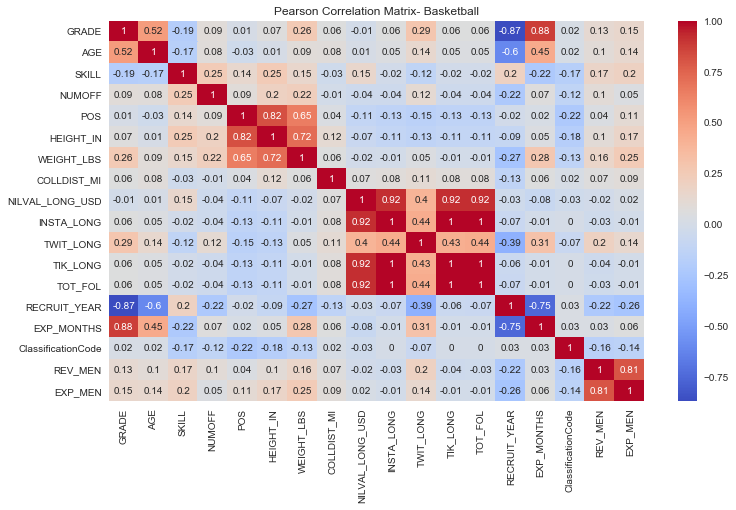

In [96]:
#Pearson Correlation matrix
plt.figure(figsize=(12,7))
plt.title('Pearson Correlation Matrix- Basketball')
sns.heatmap(df_bb.corr().round(2),annot=True, cmap = 'coolwarm')

**Feature Selection and Engineering**

Looking like there is some high correlation with Recruit year and other features (GRADE, EXP MONTHS) and TOT_FOL with othe social media counts

In [97]:
df_bb.columns

Index(['GRADE', 'AGE', 'SKILL', 'NUMOFF', 'POS', 'HEIGHT_IN', 'WEIGHT_LBS',
       'COLLDIST_MI', 'NILVAL_LONG_USD', 'INSTA_LONG', 'TWIT_LONG', 'TIK_LONG',
       'TOT_FOL', 'RECRUIT_YEAR', 'EXP_MONTHS', 'ClassificationCode',
       'REV_MEN', 'EXP_MEN'],
      dtype='object')

In [98]:
df_bb=df_bb.copy()
# df_bb
df_bb=df_bb.drop(columns=['RECRUIT_YEAR','TOT_FOL'])
df_bb.shape

(137, 16)

In [99]:
#categorical variables = GRADE, POS, CLASSIFICATIONCODE
# Select the categorical columns
categorical_subset = df_bb[['GRADE','POS','ClassificationCode']]
# one hot encode
categorical_subset = pd.get_dummies(categorical_subset)
# categorical_subset

In [100]:
#natural log transformation
#If the negative or zero values are not outliers - log1p has warning so trying small constant for social media data

df_num = df_bb.copy()

# Specify the numeric columns to log-transform
numeric_columns = ['AGE', 'SKILL', 'NUMOFF', 'HEIGHT_IN', 'WEIGHT_LBS',
                   'COLLDIST_MI', 'NILVAL_LONG_USD', 'INSTA_LONG',
                   'TWIT_LONG', 'TIK_LONG', 'EXP_MONTHS', 'REV_MEN', 'EXP_MEN']

# Apply log transformation to selected numeric columns
small_constant = 3  # Adjust as needed
for column in numeric_columns:
    df_num[column] = np.log(df_num[column] + small_constant)


df_bb2 = pd.concat([df_num, categorical_subset], axis=1)
df_bb2.head(2)

df_bb2.shape #(137, 16)

(137, 19)

In [101]:
# df_bb.columns

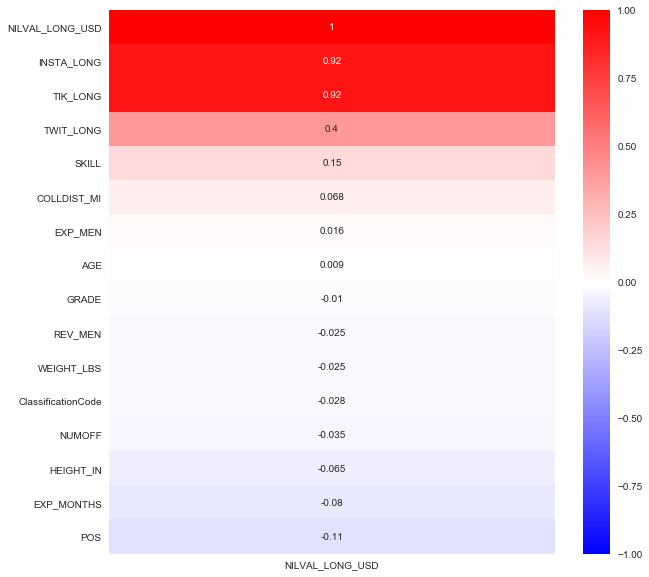

In [102]:
#Correlation heatmap
#https://stackoverflow.com/questions/72213733/how-to-plot-seaborn-heatmap-for-target-vs-independent-features
#+1= highly and positively correlated and -1 = highly negatively correlated.
def corr_plot(df):
    corr_matrix = df.corr()
    data=pd.DataFrame(corr_matrix['NILVAL_LONG_USD'].sort_values(ascending=False))  #plotting all but could do top (>.50)
  
    plt.figure(figsize = (10,10))
    return  sns.heatmap(data, annot=True, vmin=-1, vmax=1, cmap='bwr')
    # ax.tick_params(labelrotation=0)

corr_plot(df_bb)

**NAIVE BASELINE**

In [103]:

ind =['GRADE', 'AGE', 'SKILL', 'NUMOFF', 'POS', 'HEIGHT_IN', 'WEIGHT_LBS',
       'COLLDIST_MI',  'INSTA_LONG', 'TWIT_LONG', 'TIK_LONG',
       'EXP_MONTHS', 'ClassificationCode', 'REV_MEN', 'EXP_MEN']
features = df_bb[ind]
dep= [ 'NILVAL_LONG_USD']
target = df_bb[dep]

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Define the MAE function
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

# Calculate the baseline prediction
baseline_guess = np.median(y_train)

# Evaluate the baseline prediction on the test data
y_baseline_pred = np.full_like(y_test, baseline_guess)
baseline_mae = mae(y_test, y_baseline_pred)

dict = { 'Target': dep, 
        'Naive Baseline': 'Basketball',
        'Baseline MAE': baseline_mae}
base = pd.DataFrame(dict)
print("Baseline MAE:", baseline_mae)
display(base)


Baseline MAE: NILVAL_LONG_USD   97785.71
dtype: float64


,Target,Naive Baseline,Baseline MAE
NILVAL_LONG_USD,NILVAL_LONG_USD,Basketball,97785.71


**Linear Regression**

In [104]:
df_bb2.head(2)

,GRADE,AGE,SKILL,NUMOFF,POS,HEIGHT_IN,WEIGHT_LBS,COLLDIST_MI,NILVAL_LONG_USD,INSTA_LONG,TWIT_LONG,TIK_LONG,EXP_MONTHS,ClassificationCode,REV_MEN,EXP_MEN,GRADE,POS,ClassificationCode
0,2.00,3.04,4.63,3.00,1.00,4.36,5.26,7.56,13.29,7.94,7.94,1.10,1.61,1.00,15.80,16.07,2.00,1.00,1.00
1,2.00,3.04,4.61,2.77,1.00,4.36,5.26,7.62,15.62,15.58,10.09,15.57,1.61,1.00,15.80,16.07,2.00,1.00,1.00


In [105]:
train_bb, test_bb = train_test_split(df_bb2, test_size=0.30, shuffle=True, random_state=42)
print('Shape for train_bb is {0}, df_test is {1}'.format(train_bb.shape,test_bb.shape))

Shape for train_bb is (95, 19), df_test is (42, 19)


In [106]:
train_bb.head(2)

,GRADE,AGE,SKILL,NUMOFF,POS,HEIGHT_IN,WEIGHT_LBS,COLLDIST_MI,NILVAL_LONG_USD,INSTA_LONG,TWIT_LONG,TIK_LONG,EXP_MONTHS,ClassificationCode,REV_MEN,EXP_MEN,GRADE,POS,ClassificationCode
60,0.00,3.00,4.63,3.00,6.00,4.43,5.38,8.87,13.18,8.19,8.19,1.10,1.10,1.00,16.66,16.56,0.00,6.00,1.00
122,0.00,2.94,4.63,2.83,5.00,4.43,5.34,5.69,12.69,9.74,5.98,9.72,1.10,1.00,16.36,15.95,0.00,5.00,1.00


In [107]:
# train_bb
# test_bb

y_trainbb = train_bb['NILVAL_LONG_USD']
X_trainbb = train_bb.drop('NILVAL_LONG_USD',axis=1)
y_testbb= test_bb['NILVAL_LONG_USD']
X_testbb = test_bb.drop('NILVAL_LONG_USD',axis=1)

# y_testbb

In [108]:
X_trainbb.head(2)

,GRADE,AGE,SKILL,NUMOFF,POS,HEIGHT_IN,WEIGHT_LBS,COLLDIST_MI,INSTA_LONG,TWIT_LONG,TIK_LONG,EXP_MONTHS,ClassificationCode,REV_MEN,EXP_MEN,GRADE,POS,ClassificationCode
60,0.00,3.00,4.63,3.00,6.00,4.43,5.38,8.87,8.19,8.19,1.10,1.10,1.00,16.66,16.56,0.00,6.00,1.00
122,0.00,2.94,4.63,2.83,5.00,4.43,5.34,5.69,9.74,5.98,9.72,1.10,1.00,16.36,15.95,0.00,5.00,1.00


**Linear Regression - All Features**

In [109]:
#Get metrics
'''1 - r2 is the reduction in unexplained variance due to the model.
(n - 1) is the total degrees of freedom in the data.
(n - p - 1) is the degrees of freedom adjusted for the number of predictors used in the model.'''

#function for adjusted r2_score
def adjusted_r2_score(data,y_true,y_pred):
    r2 = r2_score(y_true,y_pred)
    n = data.shape[0]
    p = data.shape[1]
    adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)
    return adj_r2

#function for rmse
def rmse(y_true,y_pred):
    rmse = np.sqrt(mean_squared_error(y_true,y_pred))
    return rmse

def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

In [110]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr.fit(X_trainbb, y_trainbb)
y_pred_trainbb_lr = lr.predict(X_trainbb)
y_pred_trainorig = np.exp(y_pred_trainbb_lr)


y_pred_testbb_lr = lr.predict(X_testbb)
y_pred_testorig = np.exp(y_pred_testbb_lr )

r2_train = r2_score(y_trainbb, y_pred_trainbb_lr)
# adj_r2_train = adjusted_r2_score(X_trainbb, y_trainbb, y_pred_trainbb_lr)
# rmse_train = rmse(y_trainbb, y_pred_trainbb_lr)
rmse_train = rmse(y_trainbb, y_pred_trainorig)
# mae_train = mae(y_trainbb, y_pred_trainbb_lr)
mae_train = mae(y_trainbb, y_pred_trainbb_lr)

r2_test= r2_score(y_testbb, y_pred_testbb_lr)
# adj_r2_test = adjusted_r2_score(X_testbb, y_testbb, y_pred_testfb_lr)
# rmse_test = rmse(y_testbb, y_pred_testbb_lr)
rmse_test = rmse(y_testbb, y_pred_testorig)
# mae_test = mae(y_testbb, y_pred_testbb_lr)
mae_test = mae(y_testbb, y_pred_testorig)

print('R2 score of train data is ', r2_train)
print('rmse score of train data is ', rmse_train)
print('mae score of train data is ',mae_train)
print()
print('R2 score of test data is ',r2_test)
print('rmse score of test data is ', rmse_test)
print('mae score of test data is ', mae_test)

R2 score of train data is  0.4123626882070124
rmse score of train data is  242423.23435416847
mae score of train data is  0.47566686233229366

R2 score of test data is  0.17958421440872008
rmse score of test data is  203402.88762875617
mae score of test data is  183421.37248301454


In [111]:
results = pd.DataFrame(columns = ['Algorithm',
                                  'Train_R2 score',
                                  'Train_Adj_R2 score',
                                  'Train_RMSE score',
                                  'Train_MAE score',
                                  'Test_R2 score',
                                  'Test_Adj_R2 score',
                                  'Test_RMSE score',
                                  'Test_MAE score', 
                                #   'Mean CV R2 Score',
                                #   'Mean RMSE CV Score',
                                #   'Mean MAE CV Score'

]) 

new_lr= ['Linear Regression Basketball',
                           r2_train,
                           'na',
                           rmse_train,
                           mae_train,
                           r2_test,
                           'na',
                           rmse_test,
                           mae_test
                          
                             ]
results.loc[len(results)] = new_lr
results

,Algorithm,Train_R2 score,Train_Adj_R2 score,Train_RMSE score,Train_MAE score,Test_R2 score,Test_Adj_R2 score,Test_RMSE score,Test_MAE score
0,Linear Regression Basketball,0.41,na,242423.23,0.48,0.18,na,203402.89,183421.37


**LInear Regression Feature selection using RFE ( Recursive Feature Elimination)**

In [112]:
#features/ nof(number of features)
       

features = X_trainbb.columns.tolist()
nof_list = np.arange(1,len(features)+1)   
high_score=0

#Variable to store the optimum features-
nof=0    
score_list =[]

for n in range(len(nof_list)):
    
    lr = LinearRegression()
    rfe = RFE(lr,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_trainbb,y_trainbb)
    X_test_rfe = rfe.transform(X_testbb)
    lr.fit(X_train_rfe,y_trainbb)
    score = lr.score(X_test_rfe,y_testbb)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
        
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 2
Score with 2 features: 0.397025


In [113]:
#RFE with optima #features
lr = LinearRegression()
rfe = RFE(lr,nof)
X_trainbb_rfe = rfe.fit_transform(X_trainbb,y_trainbb)
X_testbb_rfe = rfe.transform(X_testbb)

#Fitting the data to model
lr.fit(X_trainbb_rfe,y_trainbb)              
temp = pd.Series(rfe.support_,index = features)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['SKILL', 'HEIGHT_IN'], dtype='object')


In [114]:
#predictions
y_pred_trainbb_rfe = lr.predict(X_trainbb_rfe)
y_pred_testbb_rfe = lr.predict(X_testbb_rfe)

y_pred_train_orig= np.exp(y_pred_trainbb_rfe)
y_pred_test_orig= np.exp(y_pred_testbb_rfe)

In [115]:
print('R2 score of train data is ',r2_score(y_trainbb,y_pred_trainbb_rfe))
print('Adj. R2 score of train data is ',adjusted_r2_score(X_trainbb_rfe,y_trainbb,y_pred_trainbb_rfe))
print('rmse score of train data is ',rmse(y_trainbb, y_pred_train_orig))
print('mae score of train data is ',mae(y_trainbb, y_pred_train_orig))
print()
print('R2 score of test data is ',r2_score(y_testbb, y_pred_testbb_rfe))
print('Adj. R2 score of test data is ',adjusted_r2_score(X_test_rfe,y_testbb,y_pred_testbb_rfe))
print('rmse score of test data is ',rmse(y_testbb, y_pred_test_orig))
print('mae score of test data is ',mae(y_testbb, y_pred_test_orig))





R2 score of train data is  0.22385038876601604
Adj. R2 score of train data is  0.20697757113049464
rmse score of train data is  208428.97053242254
mae score of train data is  197767.68460829792

R2 score of test data is  0.3970253694059733
Adj. R2 score of test data is  -0.07486781975456935
rmse score of test data is  192708.02634429478
mae score of test data is  181472.80915831827


In [116]:

new_rfe = ['Linear Regression_RFE Basketball (selected features)',
                             r2_score(y_trainbb, y_pred_trainbb_rfe),
                             adjusted_r2_score(X_train_rfe, y_trainbb, y_pred_trainbb_rfe),
                             rmse(y_trainbb, y_pred_train_orig),
                             mae(y_trainbb, y_pred_train_orig),
                             r2_score(y_testbb, y_pred_testbb_rfe),
                             adjusted_r2_score(X_test_rfe, y_testbb, y_pred_testbb_rfe),
                             rmse(y_testbb, y_pred_test_orig),
                             mae(y_testbb, y_pred_test_orig),
                            
                             
                             ]
results.loc[len(results)] = new_rfe
results

,Algorithm,Train_R2 score,Train_Adj_R2 score,Train_RMSE score,Train_MAE score,Test_R2 score,Test_Adj_R2 score,Test_RMSE score,Test_MAE score
0,Linear Regression Basketball,0.41,na,242423.23,0.48,0.18,na,203402.89,183421.37
1,Linear Regression_RFE Basketball (selected fea...,0.22,0.04,208428.97,197767.68,0.40,-0.07,192708.03,181472.81


In [117]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer

#cross validation 
# Fit RFE to your data
X_trainbb_rfe = rfe.fit_transform(X_trainbb, y_trainbb)

# Define the number of folds for cross-validation (e.g., 5-fold)
k = 10


# Define scoring functions for R^2, RMSE, and MAE
scoring = {
    'r2': 'r2',
    'neg_mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False),
    'neg_mean_absolute_error': make_scorer(mean_absolute_error, greater_is_better=False)
}


# Perform k-fold cross-validation and get scores
cv_results = cross_validate(lr, X_trainbb_rfe, y_trainbb, cv=k, scoring=scoring)

# Extract individual scores
r2_scores = cv_results['test_r2']
rmse_scores = np.sqrt(-cv_results['test_neg_mean_squared_error'])
mae_scores = -cv_results['test_neg_mean_absolute_error']

# Calculate the mean scores for R^2, RMSE, and MAE
mean_r2_cv = np.mean(r2_scores)
mean_rmse_cv = np.mean(rmse_scores)
mean_mae_cv = np.mean(mae_scores)

# Print the mean scores
print("Mean R2 Score:", round (mean_r2_cv,3))
print("Mean RMSE Score:", round (mean_rmse_cv,3))
print("Mean MAE Score:", round (mean_mae_cv,3))

#return DF
meancv_scores_dict = { "Model" : 'Linear Regression RFE Basketball',
    "Mean R2 CV Score": round(mean_r2_cv, 3),
    "Mean RMSE CV Score": round(mean_rmse_cv, 3),
    "Mean MAE CV Score": round(mean_mae_cv, 3)
}

meancv_scores_df = pd.DataFrame([meancv_scores_dict])

# Display the DataFrame
display(meancv_scores_df)



Mean R2 Score: 0.008
Mean RMSE Score: 0.707
Mean MAE Score: 0.532


,Model,Mean R2 CV Score,Mean RMSE CV Score,Mean MAE CV Score
0,Linear Regression RFE Basketball,0.01,0.71,0.53


**Feature Selection- Backward Elimination**
<br> Start with all features. Iteratively remove  worst performing features one by one unitl the overall model performance comes in acceptable range. p-value is performance metric.If p-value is above 0.05, then feature is removed; else keep feature

In [118]:
#https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b

import statsmodels.api as sm

# Assuming X_train and y_train are correctly defined
X_train_const = sm.add_constant(X_trainbb)  # Add a constant (intercept)
lr_sm = sm.OLS(y_trainbb, X_train_const).fit()  # Fit the linear regression model

# Now you can access the p-values
p_values = lr_sm.pvalues[1:]  
p_values

GRADE                0.47
AGE                  0.61
SKILL                0.00
NUMOFF               0.24
POS                  0.27
HEIGHT_IN            0.81
WEIGHT_LBS           0.28
COLLDIST_MI          0.06
INSTA_LONG           0.11
TWIT_LONG            0.39
TIK_LONG             0.55
EXP_MONTHS           0.29
ClassificationCode   0.24
REV_MEN              0.46
EXP_MEN              0.71
GRADE                0.47
POS                  0.27
ClassificationCode   0.24
dtype: float64

In [119]:
significance_level = 0.05

# Filter the features with p-values above the threshold
significant_features = lr_sm.pvalues[lr_sm.pvalues <= significance_level].index

# List of features to keep (those with p-values less than or equal to 0.05)
features_to_keep = list(significant_features)

# List of features to potentially eliminate (those with p-values greater than 0.05)
features_to_eliminate = list(lr_sm.pvalues[lr_sm.pvalues > significance_level].index)

# Print the significant features and features to eliminate
print("Significant Features:")
print(features_to_keep)
print("\nFeatures to Potentially Eliminate:")
print(features_to_eliminate)

Significant Features:
['const', 'SKILL']

Features to Potentially Eliminate:
['GRADE', 'AGE', 'NUMOFF', 'POS', 'HEIGHT_IN', 'WEIGHT_LBS', 'COLLDIST_MI', 'INSTA_LONG', 'TWIT_LONG', 'TIK_LONG', 'EXP_MONTHS', 'ClassificationCode', 'REV_MEN', 'EXP_MEN', 'GRADE', 'POS', 'ClassificationCode']


In [120]:



# Function for backward elimination
def backward_elimination(X, y, threshold=0.05):
    cols = X.columns
    while len(cols) > 0:
        X_1 = X[cols]
        X_1 = sm.add_constant(X_1)
        model = sm.OLS(y, X_1).fit()
        p_values = model.pvalues[1:]  # Exclude the constant term
        max_p_value = p_values.max()
        if max_p_value > threshold:
            feature_to_remove = p_values.idxmax()
            cols = cols.drop(feature_to_remove)
        else:
            break
    return cols

# Perform backward elimination
selected_features = backward_elimination(X_trainbb, y_trainbb)

# # Fit a linear regression model with the selected features
# X_train_selected = X_trainbb[selected_features]
# be_model = LinearRegression()
# be_model.fit(X_train_selected, y_trainbb)

# # Make predictions on the training set
# y_train_pred = be_model.predict(X_train_selected)

# mae_train = mean_absolute_error(y_trainbb, y_train_pred)

# # Make predictions on the test set
# X_test_selected = X_testbb[selected_features]
# y_test_pred = be_model.predict(X_test_selected)


# mae_test = mean_absolute_error(y_test, y_test_pred)

# #Evaluation 
# r2_train = r2_score(y_trainbb, y_train_pred)
# print('R2 score of train data is ',r2_train)
# adj_r2_train= adjusted_r2_score(X_trainbb,y_trainbb,y_train_pred)
# print('Adj. R2 score of train data is ',adj_r2_train)
# rmse_train = np.sqrt(mean_squared_error(y_trainbb, y_train_pred))
# print('rmse score of train data is ',rmse(y_trainbb ,y_pred_train_orig))
# mae_train = mean_absolute_error(y_trainbb, y_train_pred)
# print('mae score of train data is ',mae_train)
# print()
# r2_test = r2_score(y_testbb, y_test_pred)
# print('R2 score of test data is ',r2_test)
# adj_r2_test = adjusted_r2_score(X_testbb,y_testbb,y_test_pred)
# print('Adj. R2 score of train data is ',adj_r2_test)
# rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
# print('rmse score of test data is ', rmse_test)
# mae_test = mean_absolute_error(y_test, y_test_pred)
# print('mae score of test data is ',mae_test)

print("Selected Features:")
print(selected_features)

Selected Features:
Index(['SKILL', 'INSTA_LONG', 'TWIT_LONG'], dtype='object')


In [121]:
#get selected features
X_trainbb_be = X_trainbb[selected_features]
X_testbb_be = X_testbb[selected_features]

#building a linear regression model
lr = LinearRegression()

#fitting
lr.fit(X_trainbb_be,y_trainbb)

#predictions
y_pred_trainbb_be = lr.predict(X_trainbb_be)
y_pred_train_orig= np.exp(y_pred_trainbb_be)

y_pred_testbb_be = lr.predict(X_testbb_be)
y_pred_test_orig= np.exp(y_pred_testbb_be)

In [122]:
#Evaluation 
r2_train = r2_score(y_trainbb ,y_pred_trainbb_be)
print('R2 score of train data is ',r2_score(y_trainbb ,y_pred_trainbb_be))
adj_r2_train= adjusted_r2_score(X_trainbb_be,y_trainbb,y_pred_trainbb_be)
print('Adj. R2 score of train data is ',adjusted_r2_score(X_trainbb_be,y_trainbb,y_pred_trainbb_be))
rmse_train = rmse(y_trainbb ,y_pred_train_orig)
print('rmse score of train data is ',rmse(y_trainbb ,y_pred_train_orig))
mae_train = mae(y_trainbb,y_pred_train_orig)
print('mae score of train data is ',mae(y_trainbb,y_pred_train_orig))
print()
r2_test =r2_score(y_testbb,y_pred_testbb_be)
print('R2 score of test data is ',r2_score(y_testbb,y_pred_testbb_be))
adj_r2_test = adjusted_r2_score(X_testbb_be,y_testbb,y_pred_testbb_be)
print('Adj. R2 score of train data is ',adjusted_r2_score(X_testbb_be,y_testbb,y_pred_testbb_be))
rmse_test = rmse(y_testbb ,y_pred_test_orig)
print('rmse score of test data is ',rmse(y_testbb ,y_pred_test_orig))
mae_test =mae(y_testbb,y_pred_test_orig)
print('mae score of test data is ',mae(y_testbb,y_pred_test_orig))



new_be = ['Linear Regression_BE Basketball',
                             round(r2_train,3),
                             round(adj_r2_train, 3),
                             round(rmse_train, 3),
                             round(mae_train,3),
                             round(r2_test, 3),
                             round(adj_r2_test,3),
                             round(rmse_test,3),
                             round(mae_test, 2)
                             ]

results.loc[len(results)] = new_be
results




R2 score of train data is  0.3228628269784377
Adj. R2 score of train data is  0.3005396234722324
rmse score of train data is  230881.23322674635
mae score of train data is  206337.00090296066

R2 score of test data is  0.3513472443267083
Adj. R2 score of train data is  0.3001378162472378
rmse score of test data is  185826.26442273465
mae score of test data is  173292.09271876112


,Algorithm,Train_R2 score,Train_Adj_R2 score,Train_RMSE score,Train_MAE score,Test_R2 score,Test_Adj_R2 score,Test_RMSE score,Test_MAE score
0,Linear Regression Basketball,0.41,na,242423.23,0.48,0.18,na,203402.89,183421.37
1,Linear Regression_RFE Basketball (selected fea...,0.22,0.04,208428.97,197767.68,0.40,-0.07,192708.03,181472.81
2,Linear Regression_BE Basketball,0.32,0.30,230881.23,206337.00,0.35,0.30,185826.26,173292.09


In [123]:
#cross validation 
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer


#cross validation 
# Fit BEto your data
#fitting
lr.fit(X_trainbb_be,y_trainbb)

# Define the number of folds for cross-validation (e.g., 5-fold)
k = 10


# Define scoring functions for R^2, RMSE, and MAE
scoring = {
    'r2': 'r2',
    'neg_mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False),
    'neg_mean_absolute_error': make_scorer(mean_absolute_error, greater_is_better=False)
}

# Perform k-fold cross-validation and get scores
cv_results = cross_validate(lr, X_trainbb, y_trainbb, cv=k, scoring=scoring)

# Extract individual scores
r2_scores = cv_results['test_r2']
rmse_scores = np.sqrt(-cv_results['test_neg_mean_squared_error'])
mae_scores = -cv_results['test_neg_mean_absolute_error']

# Calculate the mean scores for R^2, RMSE, and MAE
mean_r2_cv = np.mean(r2_scores)
mean_rmse_cv = np.mean(rmse_scores)
mean_mae_cv = np.mean(mae_scores)

# Print the mean scores
print("Mean R2 CV Score:", round (mean_r2_cv,3))
print("Mean RMSE CV  Score:", round (mean_rmse_cv,3))
print("Mean MAE CV  Score:", round (mean_mae_cv,3))


#return DF
meancv_scores_dict = { "Model" : 'Linear Regression BE',
    "Mean R2 CV Score": round(mean_r2_cv, 3),
    "Mean RMSE CV Score": round(mean_rmse_cv, 3),
    "Mean MAE CV Score": round(mean_mae_cv, 3)
}

meancv_scores_df = pd.DataFrame([meancv_scores_dict])

# Display the DataFrame
display(meancv_scores_df)





Mean R2 CV Score: -1.698
Mean RMSE CV  Score: 0.964
Mean MAE CV  Score: 0.661


,Model,Mean R2 CV Score,Mean RMSE CV Score,Mean MAE CV Score
0,Linear Regression BE,-1.70,0.96,0.66


**Residual Analysis**


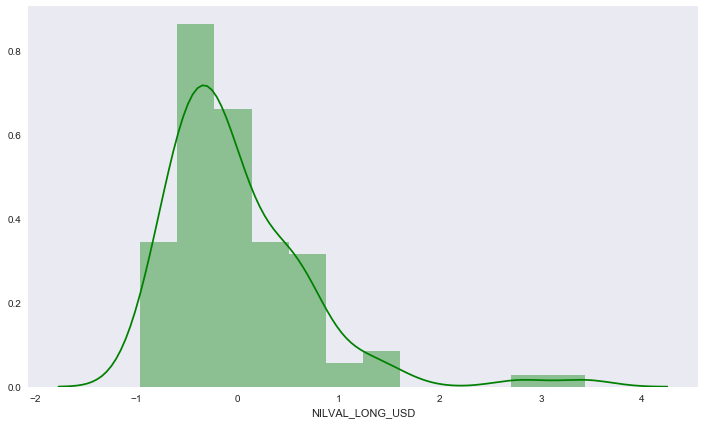

In [124]:
#check how error terms are distributed on train data for Linear Reg RFE
y_res = y_trainbb - y_pred_trainbb_rfe
plt.figure(figsize=(12,7))
sns.distplot(y_res, kde = True, color = 'g')
plt.grid()
plt.show()

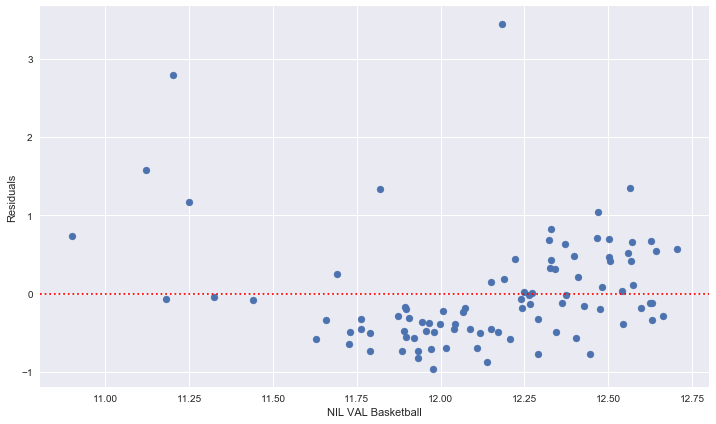

In [125]:
#residual vs predicitons plot
plt.figure(figsize=(12,7))
plt.scatter(y_pred_trainbb_rfe, y_res)
plt.axhline(y=0, color='r', linestyle=':')
plt.xlabel("NIL VAL Basketball")
plt.ylabel("Residuals")
plt.show()

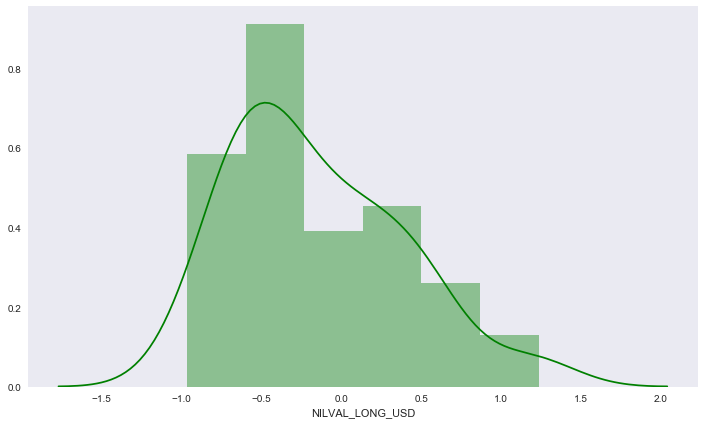

In [126]:
# error terms  distributed on test data
y_res = y_testbb- y_pred_testbb_rfe
plt.figure(figsize=(12,7))
sns.distplot(y_res, kde = True, color = 'g')
plt.grid()
plt.show()

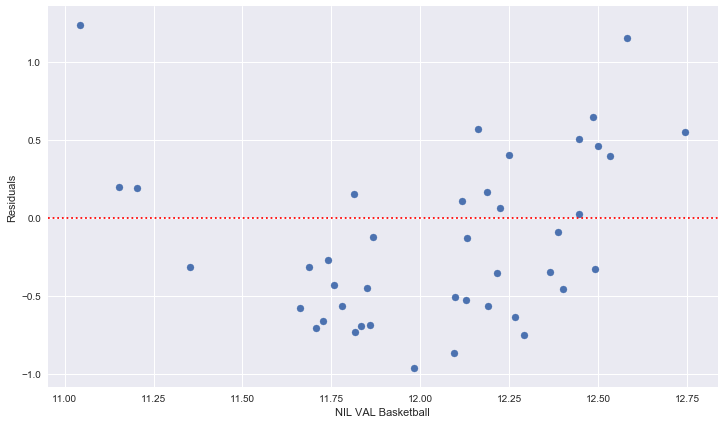

In [127]:
#residual vs predicitons plot
plt.figure(figsize=(12,7))
plt.scatter(y_pred_testbb_rfe, y_res)
plt.axhline(y=0, color='r', linestyle=':')
plt.xlabel("NIL VAL Basketball")
plt.ylabel("Residuals")
plt.show()

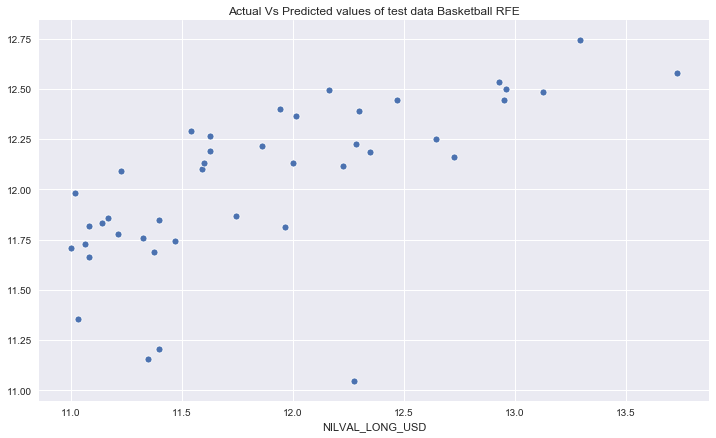

In [128]:
#actual test values vs predicted test values
plt.figure(figsize=(12,7))
plt.title('Actual Vs Predicted values of test data Basketball RFE')
sns.scatterplot(y_testbb,y_pred_testbb_rfe)
plt.show()

**Random Forest Regressor**

In [129]:
df_bb3= df_bb.copy()

In [130]:
#Get metrics
'''1 - r2 is the reduction in unexplained variance due to the model.
(n - 1) is the total degrees of freedom in the data.
(n - p - 1) is the degrees of freedom adjusted for the number of predictors used in the model.'''

#function for adjusted r2_score
def adjusted_r2_score(data,y_true,y_pred):
    r2 = r2_score(y_true,y_pred)
    n = data.shape[0]
    p = data.shape[1]
    adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)
    return adj_r2

#function for rmse
def rmse(y_true,y_pred):
    rmse = np.sqrt(mean_squared_error(y_true,y_pred))
    return rmse

def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

In [131]:
# Specify the numeric columns to log-transform
numeric_columns = ['AGE', 'SKILL', 'NUMOFF', 'HEIGHT_IN', 'WEIGHT_LBS',
                   'COLLDIST_MI', 'NILVAL_LONG_USD', 'INSTA_LONG',
                   'TWIT_LONG', 'TIK_LONG', 'EXP_MONTHS', 'REV_MEN', 'EXP_MEN']

# Apply log transformation to selected numeric columns
small_constant = 3  # Adjust as needed_fb3-
for column in numeric_columns:
    df_bb3[column] = np.log(df_bb3[column] + small_constant)

In [132]:
# df_bb.columns

In [133]:
from sklearn.ensemble import RandomForestRegressor
random_seed = 42
rf = RandomForestRegressor(random_state = random_seed)

train_bb2, test_bb2 = train_test_split(df_bb3, test_size=0.30, shuffle=True, random_state=42)
print('Shape for train_bb2 is {0}, test_bb2 is {1}'.format(train_bb2.shape,test_bb2.shape))

y_trainbb2 = train_bb2['NILVAL_LONG_USD']
X_trainbb2 = train_bb2.drop('NILVAL_LONG_USD',axis=1)
y_testbb2= test_bb2['NILVAL_LONG_USD']
X_testbb2 = test_bb2.drop('NILVAL_LONG_USD',axis=1)

Shape for train_bb2 is (95, 16), test_bb2 is (42, 16)


In [134]:
# X_trainbb.columns

In [135]:
params = {'n_estimators':[5,10,20,40,80,100,200],
          'criterion':['mse','mae'],
          'max_depth':[2,5,10,20],
          'min_samples_split':[2,4,8,12],
          'min_samples_leaf':[2,4,6,8,10],
          'oob_score': [True]}

In [136]:
#randomized search cv
rcv = RandomizedSearchCV(estimator = rf, param_distributions = params, n_iter = 10, scoring = 'r2', cv = 10, verbose=5, 
                                random_state=42, n_jobs=-1, return_train_score=True)
rcv.fit(X_trainbb2,y_trainbb2)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.8s finished


RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                             

In [137]:
# best parameters
rcv.best_params_

{'oob_score': True,
 'n_estimators': 200,
 'min_samples_split': 8,
 'min_samples_leaf': 2,
 'max_depth': 10,
 'criterion': 'mae'}

In [138]:
# best estimator
rcv.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mae',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=True,
                      random_state=42, verbose=0, warm_start=False)

In [139]:
#Best score
rcv.best_score_

0.611533447193249

In [140]:
#Building randomforest regressor with the best estimator 

# Create the Random Forest Regressor with the best estimator from hyperparameter tuning
rf1 = rcv.best_estimator_

# Fit the model
rf1.fit(X_trainbb2, y_trainbb2)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mae',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=True,
                      random_state=42, verbose=0, warm_start=False)

In [141]:
#feature importances
rf1.feature_importances_
rf1_feature_imp = pd.DataFrame(rf1.feature_importances_, index = X_trainbb2.columns, columns = ['Feature_importance'])
rf1_feature_imp.sort_values(by = 'Feature_importance', ascending = False, inplace = True)
rf1_feature_imp

,Feature_importance
SKILL,0.65
TIK_LONG,0.07
INSTA_LONG,0.05
TWIT_LONG,0.05
AGE,0.05
REV_MEN,0.03
COLLDIST_MI,0.03
EXP_MEN,0.02
NUMOFF,0.02
WEIGHT_LBS,0.02


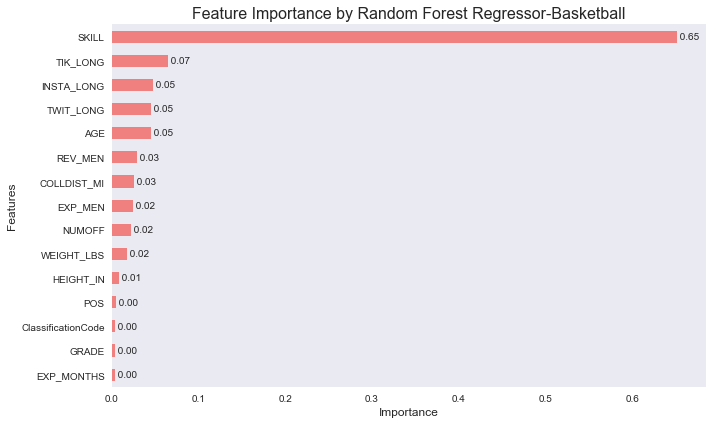

In [142]:
# Feature Visualization

rf1_feature_imp_sorted = rf1_feature_imp.sort_values(by='Feature_importance', ascending=True)

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))
plt.style.use('ggplot')

colors = ['skyblue' if x < 0 else 'lightcoral' for x in rf1_feature_imp_sorted['Feature_importance']]
rf1_feature_imp_sorted['Feature_importance'].plot(kind='barh', color=colors, ax=ax)

# Add title and labels
ax.set_title('Feature Importance by Random Forest Regressor-Basketball', fontsize=16)
ax.set_xlabel('Importance', fontsize=12)
ax.set_ylabel('Features', fontsize=12)

# Add feature names as y-tick labels
ax.set_yticklabels(rf1_feature_imp_sorted.index, fontsize=10)
plt.grid (False)

# Add importance scores at the end of the bars
for i, v in enumerate(rf1_feature_imp_sorted['Feature_importance']):
        plt.text(v, i, f' {v:.2f}', ha='left', va='center', fontsize=10, )


# Adjust the layout for better readability
plt.tight_layout()

# Show the plot
plt.show()

In [143]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

threshold_df = pd.DataFrame(columns=['Threshold', 'Num_Selected_Features', 'RMSE', 'MAE', 'R2'])

# Assuming you have already defined X_trainfb2, y_trainfb2, X_testfb2, and y_testfb2

# Building the random forest regressor with the best estimator 
rf1 = rcv.best_estimator_

# Fitting the model
rf1.fit(X_trainbb2, y_trainbb2)

# Create an array of threshold values to test
thresholds = [0.04, 0.05, 0.1, 0.15]

# Loop through each threshold value
for threshold in thresholds:
    # Create a SelectFromModel object with the current threshold
    sfm = SelectFromModel(rf1, threshold=threshold)
    
    # Fit SelectFromModel to the training data
    sfm.fit(X_trainbb2, y_trainbb2)
    
    # Get the Boolean mask of selected features
    selected_mask = sfm.get_support()
    
    # Count the number of selected features
    num_selected_features = sum(selected_mask)
    
    print(f"Threshold: {threshold}, Number of Selected Features: {num_selected_features}")

    # Train a new Random Forest model with the selected features
    X_train_selected = sfm.transform(X_trainbb2)
    X_test_selected = sfm.transform(X_testbb2)
    
    # Create a new Random Forest Regressor with the selected features
    rf_sel = RandomForestRegressor(n_estimators=80, random_state=42)
    
    # Fit the model using the selected features
    rf_sel.fit(X_train_selected, y_trainbb2)
    
    # Make predictions on the test set
    y_pred = rf_sel.predict(X_test_selected)
    
    # Evaluate the model's performance
    rmse = np.sqrt(mean_squared_error(y_testbb2, y_pred))
    mae = mean_absolute_error(y_testbb2, y_pred)
    r2 = r2_score(y_testbb2, y_pred)

     # Append the results to the DataFrame
    threshold_df = threshold_df.append({'Threshold': threshold, 
                                    'Num_Selected_Features': num_selected_features, 
                                    'RMSE': rmse, 
                                    'MAE': mae, 
                                    'R2': r2}, ignore_index=True)
    
    print(f"RMSE for Threshold {threshold}: {rmse}")
    print(f"MAE for Threshold {threshold}: {mae}")
    print(f"R-squared (R2) for Threshold {threshold}: {r2}")

threshold_df

Threshold: 0.04, Number of Selected Features: 5
RMSE for Threshold 0.04: 0.35370785071868344
MAE for Threshold 0.04: 0.22670868090418836
R-squared (R2) for Threshold 0.04: 0.7498258696251092
Threshold: 0.05, Number of Selected Features: 2
RMSE for Threshold 0.05: 0.4927589800668613
MAE for Threshold 0.05: 0.34586564989542434
R-squared (R2) for Threshold 0.05: 0.5144632628706763
Threshold: 0.1, Number of Selected Features: 1
RMSE for Threshold 0.1: 0.8240145683279675
MAE for Threshold 0.1: 0.5659430179352116
R-squared (R2) for Threshold 0.1: -0.3577592810956849
Threshold: 0.15, Number of Selected Features: 1
RMSE for Threshold 0.15: 0.8240145683279675
MAE for Threshold 0.15: 0.5659430179352116
R-squared (R2) for Threshold 0.15: -0.3577592810956849


,Threshold,Num_Selected_Features,RMSE,MAE,R2
0,0.04,5.00,0.35,0.23,0.75
1,0.05,2.00,0.49,0.35,0.51
2,0.10,1.00,0.82,0.57,-0.36
3,0.15,1.00,0.82,0.57,-0.36


In [144]:
# #consider features

feature_names = X_trainbb2.columns
sel_feat_indices =  [1, 2, 6, 11, 12, 14]
# Create a list of selected feature names based on selected_feature_indices
selected_feature_names = feature_names[sel_feat_indices]

# Print the names of the selected features
print("Selected Feature Names:")
print(selected_feature_names)

#Considering only the above features
X_trainbb_rf = X_trainbb2[selected_feature_names]
X_testbb_rf = X_testbb2[selected_feature_names]


Selected Feature Names:
Index(['AGE', 'SKILL', 'WEIGHT_LBS', 'EXP_MONTHS', 'ClassificationCode',
       'EXP_MEN'],
      dtype='object')


In [145]:
#instantiating random forest regressor
rf2 = RandomForestRegressor()

#using Randomized Search CV for hyper parameter tuning
params = {'n_estimators':[5,10,20,40,80,100,200],
          'criterion':['mse','mae'],
          'max_depth':[2,5,10,20],
          'min_samples_split':[2,4,8,12],
          'min_samples_leaf':[2,4,6,8,10],
          'oob_score': [True]}

rcv = RandomizedSearchCV(estimator = rf2, param_distributions = params, n_iter = 10, scoring = 'r2', cv = 10, verbose=5, 
                                random_state=42, n_jobs=-1, return_train_score=True)
rcv.fit(X_trainbb_rf,y_trainbb2)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.6s finished


RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                             

In [146]:
#best parameters
rcv.best_params_

{'oob_score': True,
 'n_estimators': 40,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_depth': 10,
 'criterion': 'mae'}

In [147]:
#best estimator
rcv.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mae',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=40, n_jobs=None, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

In [148]:
#best score
rcv.best_score_

0.5387337736594381

In [149]:
# rebuilding the random forest regressor using the best estimator suggested by the Randomized Search CV
rf2 = rcv.best_estimator_

#fitting on the training data
rf2.fit(X_trainbb_rf,y_trainbb2)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mae',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=40, n_jobs=None, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

In [150]:

#predictions on train data
y_pred_train = rf2.predict(X_trainbb_rf)
y_pred_trainorig = np.exp(y_pred_train)

#predictions on test data
y_pred_test = rf2.predict(X_testbb_rf)
y_pred_testorig = np.exp(y_pred_test)


r2_train = r2_score(y_trainbb2,y_pred_train)
adj_r2_train = adjusted_r2_score(X_trainbb_rf,y_trainbb2,y_pred_train )

# rmse_train = rmse(y_trainbb2,y_pred_trainorig)
rmse_train = np.sqrt(mean_squared_error(y_trainbb2, y_pred_trainorig))

# mae_train = mae(y_trainbb2,y_pred_train)
mae_train= mean_absolute_error(y_trainbb2, y_pred_trainorig)

r2_test = r2_score(y_testbb,y_pred_test)
adj_r2_test = adjusted_r2_score(X_testbb_rf,y_testbb2,y_pred_test)
# rmse_test = rmse(y_testbb2,y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_testbb2, y_pred_testorig))
# mae_test = mae(y_testbb2,y_pred_test)
mae_test = mean_absolute_error(y_testbb2, y_pred_testorig)

# #ERROR ANALYSIS






In [151]:
y_testbb2 = np.exp(y_testbb2)
actuals = y_testbb2.tolist()
predicted = y_pred_testorig.tolist()



data = {
    'Actual':  actuals,
    'Predicted': predicted
}

error = pd.DataFrame(data)

# print(y_pred_testorig)
# print(y_testbb2)
error


,Actual,Predicted
0,62003.00,117746.95
1,157003.00,105856.11
2,311003.00,355607.00
3,231003.00,249666.38
4,165003.00,159291.09
5,74003.00,87932.07
6,87003.00,96987.38
7,64003.00,118649.90
8,154003.00,180800.85
9,112003.00,119269.30


In [152]:
print('R2 score of train data is ',r2_train)
print('Adj. R2 score of train data is ',adj_r2_train)
print('rmse score of train data is ',rmse_train)
print('mae score of train data is ',mae_train)
print()
print('R2 score of test data is ',r2_test)
print('Adj. R2 score of train data is ',adj_r2_test)
print('rmse score of test data is ',rmse_test)
print('mae score of test data is ', mae_test)

#Updating the results
new_RFR= ['Random Forest regressor Basketball select features',
                            r2_train,
                            adj_r2_train,
                            rmse_train,
                            mae_train,
                            r2_test,
                            adj_r2_test,
                            rmse_test,
                            mae_test,]
                             

results.loc[len(results)] = new_RFR
results


R2 score of train data is  0.575313448276298
Adj. R2 score of train data is  0.5463575470224094
rmse score of train data is  244446.32658965272
mae score of train data is  208326.95223892582

R2 score of test data is  0.8029194158527713
Adj. R2 score of train data is  0.7691341728561035
rmse score of test data is  225536.78652306952
mae score of test data is  191631.44164047381


,Algorithm,Train_R2 score,Train_Adj_R2 score,Train_RMSE score,Train_MAE score,Test_R2 score,Test_Adj_R2 score,Test_RMSE score,Test_MAE score
0,Linear Regression Basketball,0.41,na,242423.23,0.48,0.18,na,203402.89,183421.37
1,Linear Regression_RFE Basketball (selected fea...,0.22,0.04,208428.97,197767.68,0.40,-0.07,192708.03,181472.81
2,Linear Regression_BE Basketball,0.32,0.30,230881.23,206337.00,0.35,0.30,185826.26,173292.09
3,Random Forest regressor Basketball select feat...,0.58,0.55,244446.33,208326.95,0.80,0.77,225536.79,191631.44


**Sensitivity Analysis Random Forest Regressor**

In [153]:
df_bb3.columns
X_trainbb2.columns

Index(['GRADE', 'AGE', 'SKILL', 'NUMOFF', 'POS', 'HEIGHT_IN', 'WEIGHT_LBS',
       'COLLDIST_MI', 'INSTA_LONG', 'TWIT_LONG', 'TIK_LONG', 'EXP_MONTHS',
       'ClassificationCode', 'REV_MEN', 'EXP_MEN'],
      dtype='object')

[('SKILL', 1.214165486907623), ('ClassificationCode', 0.05669624225906489), ('TWIT_LONG', 0.03369900001850468), ('INSTA_LONG', 0.02856193137183638), ('COLLDIST_MI', 0.014628741075716434), ('REV_MEN', 0.014103010477812816), ('EXP_MEN', -0.01037816866553598), ('WEIGHT_LBS', -0.005728674077627005), ('NUMOFF', -0.0037248019253723896), ('HEIGHT_IN', 0.00297926257896286), ('AGE', 0.0015224220975795788), ('GRADE', 0.0), ('POS', 0.0), ('TIK_LONG', 0.0), ('EXP_MONTHS', 0.0)]


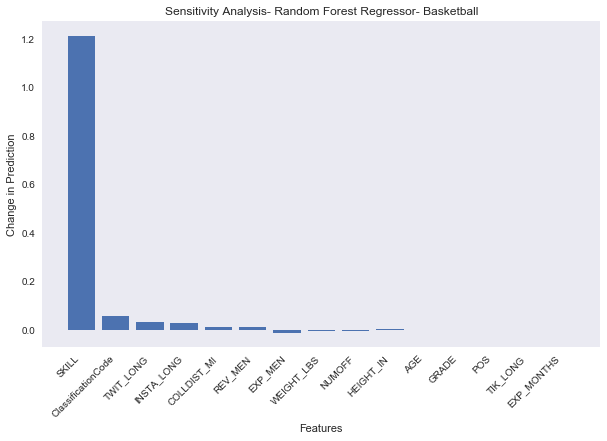

In [154]:
# Train the initial Random Forest model (RF1) using X_trainfb2 and y_trainfb2
rf1.fit(X_trainbb2, y_trainbb2)

perturbation_value = 1

# Calculate the mean feature values
mean_feature_values = X_trainbb2.mean(axis=0)

# Central data point with the mean feature values
central_data_point = mean_feature_values

# Make predictions for the central data point using the initial model (RF1)
predicted_value = rf1.predict([central_data_point])[0]

# List of features to perform sensitivity analysis on
features_to_vary = ['GRADE', 'AGE', 'SKILL', 'NUMOFF', 'POS', 'HEIGHT_IN', 'WEIGHT_LBS',
       'COLLDIST_MI', 'INSTA_LONG', 'TWIT_LONG', 'TIK_LONG', 'EXP_MONTHS',
       'ClassificationCode', 'REV_MEN', 'EXP_MEN'] 

# Convert feature names to column indices
feature_indices = [X_trainbb2.columns.get_loc(feature_to_vary) for feature_to_vary in features_to_vary]


# Store the results of sensitivity analysis
sensitivity_results = []

for feature_index in feature_indices:
    feature_name = features_to_vary[feature_index] 

    # Vary the feature value for sensitivity analysis
    perturbed_data_point = np.copy(central_data_point)
    perturbed_data_point[feature_index] += perturbation_value  # Adjust perturbation_value as needed

    # Make predictions for the perturbed data point
    perturbed_value = rf1.predict([perturbed_data_point])[0]

    # Calculate the change in prediction
    prediction_change = perturbed_value - predicted_value

    sensitivity_results.append((feature_name, prediction_change))

# Sort the sensitivity results by the magnitude of change
sensitivity_results.sort(key=lambda x: abs(x[1]), reverse=True)
print(sensitivity_results)



# Plot the sensitivity results
plt.figure(figsize=(10, 6))
plt.style.use('seaborn')
features, changes = zip(*sensitivity_results)
plt.bar(features, changes)
plt.xlabel("Features")
plt.ylabel("Change in Prediction")
plt.xticks(rotation=45, ha="right")  
plt.grid(False)
plt.title("Sensitivity Analysis- Random Forest Regressor- Basketball")
plt.show()





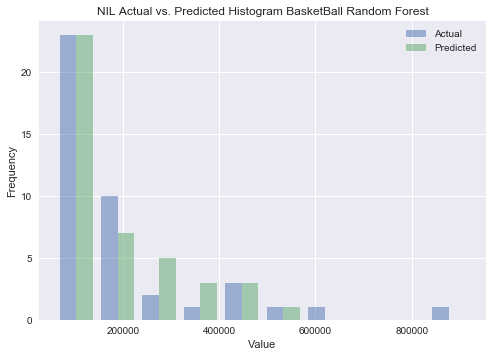

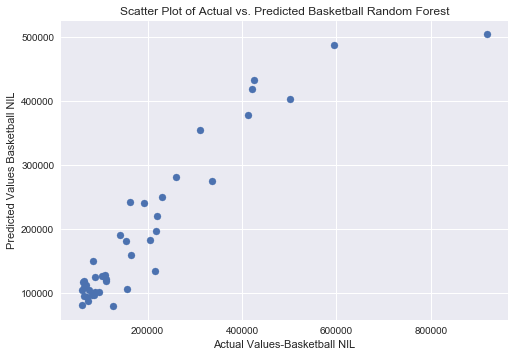

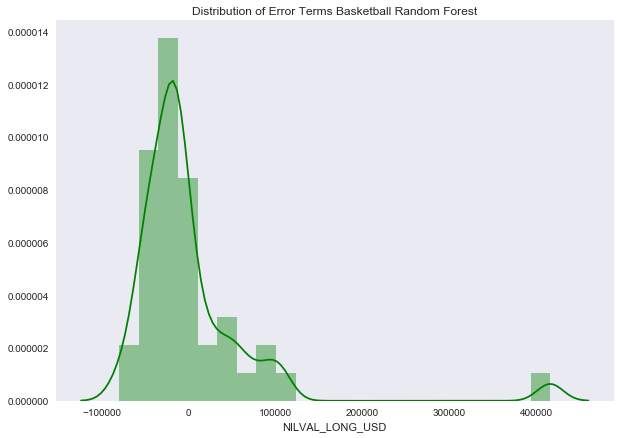

In [155]:

# Plotting a histogram
plt.hist([error['Actual'], error['Predicted']], bins=10, alpha=0.5, label=['Actual', 'Predicted'])
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('NIL Actual vs. Predicted Histogram BasketBall Random Forest')
plt.show()

# Create a scatter plot
plt.scatter(error['Actual'], error['Predicted'])
plt.xlabel('Actual Values-Basketball NIL')
plt.ylabel('Predicted Values Basketball NIL')
plt.title('Scatter Plot of Actual vs. Predicted Basketball Random Forest')
plt.show()


#check how error terms are distributed on train data for Linear Reg RFE
y_res = y_testbb2 - y_pred_testorig
plt.figure(figsize=(10,7))
sns.distplot(y_res, kde = True, color = 'g')
plt.title('Distribution of Error Terms Basketball Random Forest')
plt.grid()
plt.show()


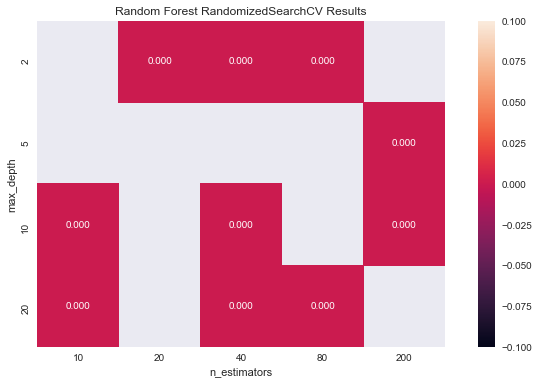

In [156]:
rcv_rf_results = rcv.cv_results_
# print (rcv_rf_results['param_n_estimators'])

param_n_estimators = None
param_max_depth = None
mean_test_score = None
try:
    param_n_estimators = rcv_rf_results['param_n_estimators']
    param_max_depth = rcv_rf_results['param_max_depth']
    mean_test_score = rcv_rf_results['mean_test_score']
except (ValueError, TypeError):
    # Handle data type conversion errors here
    print("Data type conversion error occurred.")

# Create a pivot table for heatmap
data = pd.DataFrame({'n_estimators': param_n_estimators, 'max_depth': param_max_depth, 'Mean R-squared': mean_test_score})

# Check if the 'n_estimators' column contains "?" or other invalid values
data['n_estimators']= data['n_estimators'].astype(int)
data['max_depth'] = data['max_depth'].astype(int)
data['Mean R-squared'] = data['Mean R-squared'].astype(int)


# # Create the pivot table

plt.figure(figsize=(12, 6))
sns.heatmap(data.pivot_table(index='max_depth', columns='n_estimators', values='Mean R-squared'),
            annot=True, fmt=".3f", cbar=True, square=True)
plt.title('Random Forest RandomizedSearchCV Results')
plt.show()



**Random Forest Feature Ablation**

In [157]:
# Initialize variables to store feature importance and performance changes
feature_importance = rf1.feature_importances_
feature_names = X_trainbb2.columns  # Replace with your feature names
ablation_mae = []
ablation_r2 = []

rf1.fit(X_trainbb2, y_trainbb2)
y_pred = rf1.predict(X_testbb2)
baseline_mae = mean_absolute_error(y_testbb2, y_pred_test)
baseline_r2 = r2_score(y_testbb2, y_pred_test)

for i in range(X_trainbb2.shape[1]):
    # Temporarily remove one feature at a time
    reduced_X_train = X_trainbb2.drop(columns= feature_names[i])
    X_test_reduced = X_testbb2.drop(columns=feature_names[i])

    # Train a new Random Forest model with one feature removed
    rf1.fit(reduced_X_train, y_trainbb2)
    y_pred = rf1.predict(X_test_reduced)
    
    # Calculate MSE and R-squared for the reduced model
    mae = mean_absolute_error(y_testbb2, y_pred)
    r2 = r2_score(y_testbb2, y_pred)
    
    ablation_mae.append(mae)
    ablation_r2.append(r2)
    
    print(f"Removed {feature_names[i]} - Ablation MAE: {mae}, Ablation R-squared: {r2}")

# # Compare the change in performance metrics with each feature removed
for i, feature in enumerate(feature_names):
    mae_change = baseline_mae - ablation_mae[i]
    r2_change = ablation_r2[i] - baseline_r2
    print(f"Removed {feature}: MAE Change: {mae_change}, R-squared Change: {r2_change}")

    # Create a list of dictionaries to store the results
ab_results = []

for i, feature in enumerate(feature_names):
    mae_change = baseline_mae - ablation_mae[i]
    r2_change = ablation_r2[i] - baseline_r2
    result_dict = {
        "Feature Removed": feature,
        "MAE Change": mae_change,
        "R-squared Change": r2_change
    }
    ab_results.append(result_dict)

# Convert the list of dictionaries to a Pandas DataFrame
ablation_df = pd.DataFrame(ab_results)

# Display the DataFrame
display(ablation_df)


Removed GRADE - Ablation MAE: 193014.82670105237, Ablation R-squared: -1.247113257467284
Removed AGE - Ablation MAE: 193014.82949085697, Ablation R-squared: -1.2471134775926949
Removed SKILL - Ablation MAE: 193014.76937087005, Ablation R-squared: -1.2471166695099214
Removed NUMOFF - Ablation MAE: 193014.83239579038, Ablation R-squared: -1.2471132688205007
Removed POS - Ablation MAE: 193014.8295914075, Ablation R-squared: -1.2471132375669618
Removed HEIGHT_IN - Ablation MAE: 193014.83103050213, Ablation R-squared: -1.2471132629287616
Removed WEIGHT_LBS - Ablation MAE: 193014.8246716244, Ablation R-squared: -1.2471132374162273
Removed COLLDIST_MI - Ablation MAE: 193014.8271845965, Ablation R-squared: -1.2471132424717384
Removed INSTA_LONG - Ablation MAE: 193014.81330209557, Ablation R-squared: -1.2471130863023046
Removed TWIT_LONG - Ablation MAE: 193014.82063330186, Ablation R-squared: -1.2471130828030974
Removed TIK_LONG - Ablation MAE: 193014.822853095, Ablation R-squared: -1.247113141

,Feature Removed,MAE Change,R-squared Change
0,GRADE,-0.02,-0.00
1,AGE,-0.02,-0.00
2,SKILL,0.04,-0.00
3,NUMOFF,-0.03,-0.00
4,POS,-0.02,-0.00
5,HEIGHT_IN,-0.03,-0.00
6,WEIGHT_LBS,-0.02,-0.00
7,COLLDIST_MI,-0.02,-0.00
8,INSTA_LONG,-0.01,-0.00
9,TWIT_LONG,-0.02,-0.00


In [158]:
X_trainbb2.columns

Index(['GRADE', 'AGE', 'SKILL', 'NUMOFF', 'POS', 'HEIGHT_IN', 'WEIGHT_LBS',
       'COLLDIST_MI', 'INSTA_LONG', 'TWIT_LONG', 'TIK_LONG', 'EXP_MONTHS',
       'ClassificationCode', 'REV_MEN', 'EXP_MEN'],
      dtype='object')

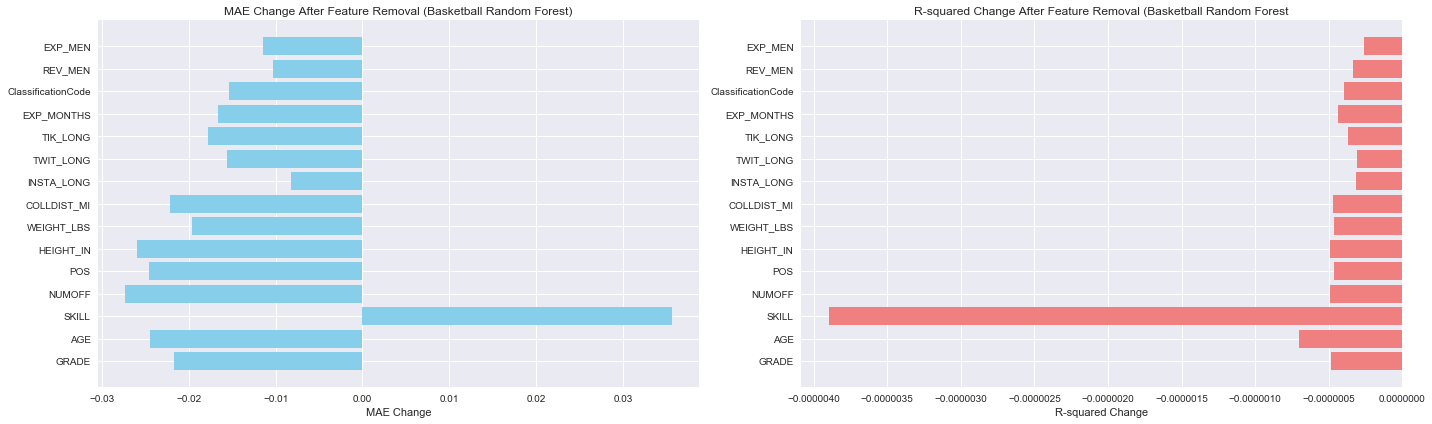

In [159]:
#visualize ablation 


fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Bar chart for MAE change
axes[0].barh(ablation_df["Feature Removed"], ablation_df["MAE Change"], color='skyblue')
axes[0].set_xlabel('MAE Change')
axes[0].set_title('MAE Change After Feature Removal (Basketball Random Forest)')

# Bar chart for R-squared change
axes[1].barh(ablation_df["Feature Removed"], ablation_df["R-squared Change"], color='lightcoral')
axes[1].set_xlabel('R-squared Change')
axes[1].set_title('R-squared Change After Feature Removal (Basketball Random Forest')

plt.tight_layout()
plt.show()

**Random Forrest Error Analysis**

In [160]:
# errors

No handles with labels found to put in legend.


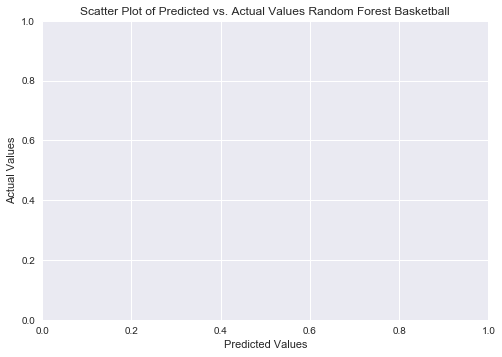

In [161]:



# # errors = y_testbb2 - y_pred_testorig
# # # print(len(errors))

# # # # # Identify examples where prediction failed
# # threshold = 0.05  # Set your own threshold for what constitutes a prediction failure
# # failed_examples = X_testbb2[np.abs(errors) > threshold]

# # # # # Print and visualize failed examples
# # # print("Failed Examples:")
# # print(failed_examples)

# x_range = (min(y_testbb2), max(y_testbb2))
# y_range = (min(y_pred_testorig), max(y_pred_testorig))


# # plt.scatter(y_pred_testorig, y_testbb2, label='Actual', c='b', alpha=0.5, marker='o', edgecolor='b')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Scatter Plot of Predicted vs. Actual Values Random Forest Basketball')
plt.legend()
plt.show()

**Random Forest CV**

In [162]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
import pandas as pd


rf2 = rcv.best_estimator_

# Set the number of folds (k) for cross-validation, e.g., 5-fold
k = 5

# Define custom scoring functions for MAE and RMSE
scoring = {
    'r2': make_scorer(r2_score),
    'neg_mean_absolute_error': make_scorer(mean_absolute_error, greater_is_better=False),
    'neg_mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False)
}

# Perform k-fold cross-validation with custom scoring functions
cv_results = cross_validate(rf2, X_trainbb2, y_trainbb2, cv=k, scoring=scoring)

# Calculate mean scores
mean_r2_cv = np.mean(cv_results['test_r2'])
mean_mae_cv = np.mean(-cv_results['test_neg_mean_absolute_error'])
mean_rmse_score = np.mean(np.sqrt(-cv_results['test_neg_mean_squared_error']))

# Create a dictionary with the results
cv_scores_dict = {
    "Model": 'Random Forest CV Basketball ',
    "Mean R2 CV Score": mean_r2_cv,
    "Mean MAE CV Score": mean_mae_cv,
    "Mean RMSE CV Score": mean_rmse_score
}

# Convert the dictionary to a Pandas DataFrame
cv_scores_df = pd.DataFrame([cv_scores_dict])

# Display the DataFrame
display(cv_scores_df)

,Model,Mean R2 CV Score,Mean MAE CV Score,Mean RMSE CV Score
0,Random Forest CV Basketball,0.42,0.35,0.57


**XGBoost**


In [163]:
xgbr = XGBRegressor()

params = {
          'learning_rate': [0.1,0.2,0.5,0.8,1],
          'max_depth': [2,3,4,5,6,7,8,10],
          'subsample': [0.001,0.009,0.01,0.09,0.1,0.4,0.9,1],
          'min_child_weight': [1,2,4,5,8],
          'gamma': [0.0,0.1,0.2,0.3],
          'colsample_bytree': [0.3,0.5,0.7,1.0,1.4],
          'reg_alpha': [0,0.1,0.2,0.4,0.5,0.7,0.9,1,4,8,10,50,100],
          'reg_lambda': [1,4,5,10,20,50,100,200,500,800,1000]
          
         }

#Using Randomized search cv
rcv = RandomizedSearchCV(estimator=xgbr, param_distributions=params, n_iter = 10, 
                                scoring='r2', cv = 10, verbose=2, 
                                random_state=42, n_jobs=-1, return_train_score=True)
rcv.fit(X_trainbb2,y_trainbb2)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.7s finished


RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=No...
                                        'learning_rate': [0.1, 0.2, 0.5, 0.8,
                                                          1],
         

In [164]:
# best estimator
rcv.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.2, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='', learning_rate=1,
             max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=4,
             max_leaves=0, min_child_weight=4, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=0, reg_alpha=0.5, ...)

In [165]:
# best estimator
rcv.best_params_

{'subsample': 0.9,
 'reg_lambda': 1000,
 'reg_alpha': 0.5,
 'min_child_weight': 4,
 'max_depth': 4,
 'learning_rate': 1,
 'gamma': 0.2,
 'colsample_bytree': 0.5}

In [166]:
#best score
rcv.best_score_

0.20306975616477851

In [167]:
#Building XGboost regressor with best hyperparameters
xgbr = rcv.best_estimator_
#Fitting on train data
xgbr.fit(X_trainbb2,y_trainbb2)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.2, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='', learning_rate=1,
             max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=4,
             max_leaves=0, min_child_weight=4, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=0, reg_alpha=0.5, ...)

In [168]:
#feature importances
xgbr_feature_imp = pd.DataFrame(xgbr.feature_importances_, index = X_trainbb2.columns, columns=['Feature_importance'])
xgbr_feature_imp.sort_values(by = 'Feature_importance', ascending = False, inplace = True)
xgbr_feature_imp

,Feature_importance
SKILL,0.62
TIK_LONG,0.38
GRADE,0.00
AGE,0.00
NUMOFF,0.00
POS,0.00
HEIGHT_IN,0.00
WEIGHT_LBS,0.00
COLLDIST_MI,0.00
INSTA_LONG,0.00


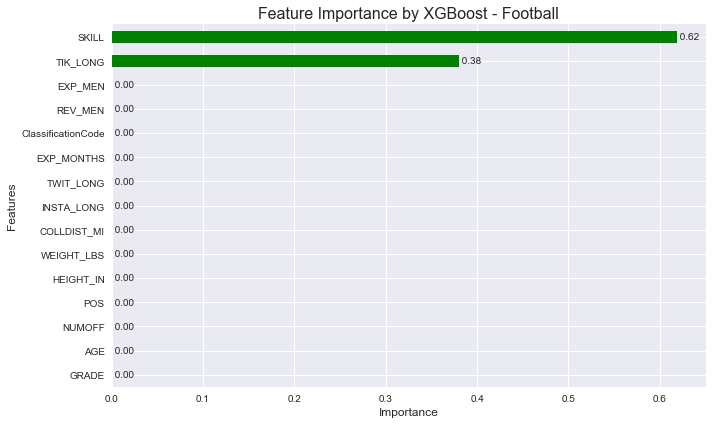

In [169]:
# Feature Visualization
xgbr_feature_imp = pd.DataFrame(xgbr.feature_importances_, index=X_trainbb2.columns, columns=['Feature_importance'])
xgbr_feature_imp.sort_values(by='Feature_importance', ascending=True, inplace=True)


fig, ax = plt.subplots(figsize=(10, 6))
plt.style.use('ggplot')

colors = ['skyblue' if x < 0 else 'green' for x in xgbr_feature_imp['Feature_importance']]
xgbr_feature_imp['Feature_importance'].plot(kind='barh', color=colors, ax=ax)

# Add title and labels
ax.set_title('Feature Importance by XGBoost - Football', fontsize=16)
ax.set_xlabel('Importance', fontsize=12)
ax.set_ylabel('Features', fontsize=12)

# Add feature names as y-tick labels
ax.set_yticklabels(xgbr_feature_imp.index, fontsize=10)

# Add importance scores at the end of the bars
for i, v in enumerate(xgbr_feature_imp['Feature_importance']):
        plt.text(v, i, f' {v:.2f}', ha='left', va='center', fontsize=10, )

# Adjust the layout for better readability
plt.tight_layout()

# Show the plot
plt.show()

In [170]:
#consider top 4 features
xgbr_top_features =  ['GRADE','SKILL',  'INSTA_LONG', 'POS']

In [171]:
X_train_xgbr2 = X_trainbb2[xgbr_top_features]
X_test_xgbr2 = X_testbb2[xgbr_top_features]

In [172]:
#Fitting on the training data
xgbr2 = XGBRegressor()
params = {
          'learning_rate': [0.1,0.2,0.5,0.8,1],
          'max_depth': [2,3,4,5,6,7,8,10],
          'subsample': [0.001,0.009,0.01,0.09,0.1,0.4,0.9,1],
          'min_child_weight': [1,2,4,5,8],
          'gamma': [0.0,0.1,0.2,0.3],
          'colsample_bytree': [0.3,0.5,0.7,1.0,1.4],
          'reg_alpha': [0,0.1,0.2,0.4,0.5,0.7,0.9,1,4,8,10,50,100],
          'reg_lambda': [1,4,5,10,20,50,100,200,500,800,1000]
          
         }

#Using Randomized search cv
rcv = RandomizedSearchCV(estimator=xgbr2, param_distributions=params, n_iter = 10, 
                                scoring='r2', cv = 10, verbose=2, 
                                random_state=42, n_jobs=-1, return_train_score=True)
rcv.fit(X_train_xgbr2,y_trainbb2)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  85 out of 100 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished


RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=No...
                                        'learning_rate': [0.1, 0.2, 0.5, 0.8,
                                                          1],
         

In [173]:
#best estimator
rcv.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.2, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='', learning_rate=1,
             max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=4,
             max_leaves=0, min_child_weight=4, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=0, reg_alpha=0.5, ...)

In [174]:
#best params
rcv.best_params_

{'subsample': 0.9,
 'reg_lambda': 1000,
 'reg_alpha': 0.5,
 'min_child_weight': 4,
 'max_depth': 4,
 'learning_rate': 1,
 'gamma': 0.2,
 'colsample_bytree': 0.5}

In [175]:
#best score
rcv.best_score_

0.21579832951962002

In [176]:
xgbr2 = rcv.best_estimator_
#fitting
xgbr2.fit(X_train_xgbr2, y_trainbb2)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.2, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='', learning_rate=1,
             max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=4,
             max_leaves=0, min_child_weight=4, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=0, reg_alpha=0.5, ...)

In [177]:
#function for adjusted r2_score
def adjusted_r2_score(data,y_true,y_pred):
    r2 = r2_score(y_true,y_pred)
    n = data.shape[0]
    p = data.shape[1]
    adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)
    return adj_r2

#function for rmse
def rmse(y_true,y_pred):
    rmse = np.sqrt(mean_squared_error(y_true,y_pred))
    return rmse

def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)


#Predictions on train data
y_pred_train = xgbr2.predict(X_train_xgbr2)
y_pred_trainorig = np.exp(y_pred_train)

#predictions on test data
y_pred_test = xgbr2.predict(X_test_xgbr2)
y_pred_testorig = np.exp(y_pred_test)


r2_train= r2_score(y_trainbb2 ,y_pred_train)
adj_r2_train = adjusted_r2_score(X_train_xgbr2,y_trainbb2 ,y_pred_train)
rmse_train = rmse(y_trainbb2 ,y_pred_trainorig)
mae_train = (y_trainbb2 ,y_pred_trainorig)

r2_test = r2_score(y_testbb2 ,y_pred_test)
adj_r2_test = adjusted_r2_score(X_test_xgbr2,y_testbb2,y_pred_test)
rmse_train = rmse(y_testbb2,y_pred_testorig)
mae_train = mae(y_testbb2,y_pred_testorig)

print('R2 score of train data is ',r2_train)
print('Adj. R2 score of train data is ',adj_r2_train)
print('rmse score of train data is ',rmse_train)
print('mae score of train data is ',mae_train)
print()
print('R2 score of test data is ',r2_test)
print('Adj. R2 score of train data is ',adj_r2_test)
print('rmse score of test data is ', rmse_test)
print('maescore of test data is ',mae_test)

# #storing in results
# new_xgb= ['XG Boost regressor',
#           r2_train,
#           adj_r2_train,
#           rmse_train,
#           mae_train,
#           r2_test,
#           adj_r2_test,
#           rmse_test,
#           mae_test,
                             
#                              ]

# results.loc[len(results)] = new_xgb
# results


R2 score of train data is  0.3225128981704086
Adj. R2 score of train data is  0.2924023603113157
rmse score of train data is  142735.73568318356
mae score of train data is  89409.56212797615

R2 score of test data is  -1.2471151348230607
Adj. R2 score of train data is  -1.490046500749878
rmse score of test data is  225536.78652306952
maescore of test data is  191631.44164047381


In [178]:
print('R2 score of train data is ',r2_train)
print('Adj. R2 score of train data is ',adj_r2_train)
print('rmse score of train data is ',rmse_train)
print('mae score of train data is ',mae_train)
print()
print('R2 score of test data is ',r2_test)
print('Adj. R2 score of train data is ',adj_r2_test)
print('rmse score of test data is ', rmse_test)
print('maescore of test data is ',mae_test)

#storing in results
new_xgb= ['XG Boost regressor Basketball',
          r2_train,
          adj_r2_train,
          rmse_train,
          mae_train,
          r2_test,
          adj_r2_test,
          rmse_test,
          mae_test,
                             
                             ]

results.loc[len(results)] = new_xgb
results

R2 score of train data is  0.3225128981704086
Adj. R2 score of train data is  0.2924023603113157
rmse score of train data is  142735.73568318356
mae score of train data is  89409.56212797615

R2 score of test data is  -1.2471151348230607
Adj. R2 score of train data is  -1.490046500749878
rmse score of test data is  225536.78652306952
maescore of test data is  191631.44164047381


,Algorithm,Train_R2 score,Train_Adj_R2 score,Train_RMSE score,Train_MAE score,Test_R2 score,Test_Adj_R2 score,Test_RMSE score,Test_MAE score
0,Linear Regression Basketball,0.41,na,242423.23,0.48,0.18,na,203402.89,183421.37
1,Linear Regression_RFE Basketball (selected fea...,0.22,0.04,208428.97,197767.68,0.40,-0.07,192708.03,181472.81
2,Linear Regression_BE Basketball,0.32,0.30,230881.23,206337.00,0.35,0.30,185826.26,173292.09
3,Random Forest regressor Basketball select feat...,0.58,0.55,244446.33,208326.95,0.80,0.77,225536.79,191631.44
4,XG Boost regressor Basketball,0.32,0.29,142735.74,89409.56,-1.25,-1.49,225536.79,191631.44


In [179]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
import pandas as pd

# Define your XGBoost Regressor model
xgbr2 = rcv.best_estimator_

# Assuming X_train_xgbr and y_trainbb are your training data
# Set the number of folds (k) for cross-validation, e.g., 5-fold
k = 5

# Define custom scoring functions for MAE and RMSE
scoring = {
    'r2': make_scorer(r2_score),
    'neg_mean_absolute_error': make_scorer(mean_absolute_error, greater_is_better=False),
    'neg_mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False)
}

# Perform k-fold cross-validation with custom scoring functions
cv_results = cross_validate(xgbr2, X_train_xgbr2, y_trainbb2, cv=k, scoring=scoring)

# Calculate mean scores
mean_r2_cv = np.mean(cv_results['test_r2'])
mean_mae_cv = np.mean(-cv_results['test_neg_mean_absolute_error'])
mean_rmse_score = np.mean(np.sqrt(-cv_results['test_neg_mean_squared_error']))

# Create a dictionary with the results
cv_scores_dict = {
    "Model": 'XGBoost CV',
    "Mean R2 CV Score": mean_r2_cv,
    "Mean MAE CV Score": mean_mae_cv,
    "Mean RMSE CV Score": mean_rmse_score
}

# Convert the dictionary to a Pandas DataFrame
cv_scores_df = pd.DataFrame([cv_scores_dict])

# Display the DataFrame
display(cv_scores_df)


,Model,Mean R2 CV Score,Mean MAE CV Score,Mean RMSE CV Score
0,XGBoost CV,0.19,0.53,0.70


**Random Forest Loop**

In [180]:
X_trainbb2.columns

Index(['GRADE', 'AGE', 'SKILL', 'NUMOFF', 'POS', 'HEIGHT_IN', 'WEIGHT_LBS',
       'COLLDIST_MI', 'INSTA_LONG', 'TWIT_LONG', 'TIK_LONG', 'EXP_MONTHS',
       'ClassificationCode', 'REV_MEN', 'EXP_MEN'],
      dtype='object')

In [181]:
y_trainbb2

60    13.18
122   12.69
93    12.15
44    11.49
15    12.98
       ... 
71    11.35
106   12.70
14    12.92
92    11.61
102   12.27
Name: NILVAL_LONG_USD, Length: 95, dtype: float64

In [182]:
# pip install joblib

In [183]:
from itertools import combinations
from joblib import Parallel, delayed

target_column = 'NILVAL_LONG_USD'  # Change to a string (not a set)
feature_columns = ['GRADE', 'AGE', 'SKILL', 'NUMOFF', 'POS', 'HEIGHT_IN', 'WEIGHT_LBS',
       'COLLDIST_MI', 'INSTA_LONG', 'TWIT_LONG', 'TIK_LONG', 'EXP_MONTHS',
       'ClassificationCode', 'REV_MEN', 'EXP_MEN']

# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Feature_Combo', 'MAE_Score', 'MAE', 'Num_Selected_Features', 'R2', 'RMSE', 'Threshold'])

# Initialize the RandomForestRegressor
rf1 = RandomForestRegressor(n_estimators=100, random_state=0)
# Function to train a model for a given feature combination and threshold
def train_model(selected_features, threshold):
    # Create a new instance of the RandomForestRegressor for each parallel task
    rf = RandomForestRegressor(n_estimators=100, random_state=0)
    
    # Fit the model using only the selected features
    rf.fit(X_trainbb2[selected_features], y_trainbb2)
    
    # Make predictions on the test data
    predictions = rf.predict(X_testbb2[selected_features])
    
    # Calculate the MAE for this combination of features
    mae = mean_absolute_error(y_testbb2, predictions)
    
    return {'Feature_Combo': ', '.join(selected_features), 'MAE_Score': mae, 'MAE': mae,
            'Num_Selected_Features': len(selected_features), 'R2': r2, 'RMSE': rmse, 'Threshold': threshold}

# List to store results
results = []

# Iterate through different combinations of features and thresholds in parallel
for threshold in thresholds:
    for r in range(1, len(feature_columns) + 1):
        feature_combos = combinations(feature_columns, r)
        results.extend(Parallel(n_jobs=-1)(delayed(train_model)(list(combo), threshold) for combo in feature_combos))

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Sort the results by MAE in ascending order
results_df = results_df.sort_values(by='MAE_Score')

# Print or return the results DataFrame
print(results_df)


In [ ]:
results_df